In [28]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow
# %pip install -U imbalanced-learn

In [29]:
import numpy as np
import pandas as pd

In [30]:
COMMODITY = 'cobalt'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
BRENT_OIL_COLUMN = 'Brent Oil Value'
WTI_OIL_COLUMN = 'WTI Oil Value'

VALUE_SPIKES_COLUMN = 'Value Spikes'  
QUANTITY_SPIKES_COLUMN = 'Std. Quantity (KG) Spikes'
UNIT_RATE_SPIKES_COLUMN = 'Std. Unit Rate ($/KG) Spikes'

BRENT_OIL_SPIKES_COLUMN = 'Brent Oil Value'
WTI_OIL_SPIKES_COLUMN = 'WTI Oil Value'

SHIP_COUNT_COLUMN = 'ship_count'
PORT_COUNT_COLUMN = 'popular_port_count'

ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../../volza/{COMMODITY}/{COMMODITY}_prices2.csv"
AIS_POPULAR_FILE_PATH = f'../../ais/ais_ml_features.csv' 

NB_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (No Balancing).csv"
RUS_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (Random Under Sampling).csv"
ROS_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (Random Over Sampling).csv"


SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20
BIN_COUNT = 5
FILL_METHOD = 'ffill'

RANDOM_STATE = 42

In [31]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Spike detection

In [32]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_kg(volza_pd)
volza_pd.head(3)

,ID,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (KG),Std. Unit Rate ($/KG)
0,0,2020-03-03,81052029000K,BRAND: HANRUI COBALT|EFS 1 GRANULATE COBA,TANTAL ARGENTINA SRL,NaN,NaN,200.0,KGS,-,...,-,-,OTHERS,0.0,NaN,NaN,NaN,Argentina T2 Import,200.0,42.805000
1,1,2020-11-25,8105200000,DO 3202000987-001 DECLARATION (1-1) INVOICE: 2...,INVERSIONES RINCON MEDINA LTDA,NaN,GE ADDITIVE,11.0,KGS,-,...,-,-,COBALT MATTES AND OTHER INTERMEDIATE PRODUCTS ...,11.0,CRA 47 79 234,101 NORTH CAMPUS DRIVR IMPERIAL PA15126,NaN,Columbia T3+ Import,11.0,251.360909
3,3,2020-12-14,81052000,"COBALT DUST: ""BEGO WIROBOND C+""-10PCS*5K",BELADENT SRL MOLDOVA OR NISPORENI,NaN,OOO SIMPLAND 121353 OR MOSCOVA SK,50.0,KGS,-,...,-,-,NaN,0.0,MOLDOVA OR NISPORENI,NaN,NaN,Moldova T3 Import,50.0,384.074400


In [33]:
#Preprocessing the AIS data
ais_popular_pd = pd.read_csv(AIS_POPULAR_FILE_PATH)
# volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
ais_popular_pd['Date'] = pd.to_datetime(ais_popular_pd['Date'])
ais_popular_pd.head(3)


,Date,ship_count,popular_port,popular_port_count
0,2020-11-10,8,LTKLJ,18
1,2020-11-12,20,IDSKP,8
2,2020-11-29,9,CNSHA,2


In [34]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
# prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%m/%d/%Y')
# prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd['Price'] = prices_pd['Price'].astype(float)
prices_pd = prices_pd[['Date', 'Price']]
prices_pd

,Date,Price
0,2023-12-29,15.8
1,2023-12-28,15.8
2,2023-12-27,15.8
3,2023-12-26,15.8
4,2023-12-25,15.8
...,...,...
947,2020-01-08,15.5
948,2020-01-07,15.5
949,2020-01-06,15.5
950,2020-01-03,15.5


In [35]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[[VALUE_COLUMN,QUANTITY_COLUMN,'Gross Weight']].sum()

In [36]:
# Avg of Commodity Price in Volza
avg_price_volza = volza_pd.groupby('Date')[UNIT_RATE_COLUMN].mean()
date_wise_volza = date_wise_volza.join(avg_price_volza, how='left')
date_wise_volza

,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG)
Date,,,,
2020-01-01,1.217433e+08,4.147777e+06,42055.0,92.545195
2020-01-02,9.020977e+04,2.300000e+03,0.0,39.903707
2020-01-03,4.110707e+02,1.000000e+01,0.0,41.107069
2020-01-04,5.637466e+04,1.000000e+03,0.0,56.374664
2020-01-05,4.051522e+04,1.140000e+03,0.0,35.644705
...,...,...,...,...
2023-12-25,8.913675e+04,3.000000e+03,0.0,30.255888
2023-12-26,1.160515e+05,3.000000e+03,0.0,38.338660
2023-12-27,5.611000e+04,1.841780e+03,0.0,46.549676


In [37]:
# Petroleum data prep
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


C:\Users\manim\AppData\Local\Temp\ipykernel_17840\273638861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
C:\Users\manim\AppData\Local\Temp\ipykernel_17840\273638861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


In [38]:
# Combining dataframes
prices_pd = prices_pd.set_index('Date')
ais_popular_pd = ais_popular_pd.set_index('Date')
date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
# date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method='ffill')
aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df

C:\Users\manim\AppData\Local\Temp\ipykernel_17840\261862122.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_17840\261862122.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_17840\261862122.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_17840\261862122.py:8: FutureWarnin

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value
0,2020-01-01,1.217433e+08,4.147777e+06,42055.0,92.545195,NaN,NaN,NaN,NaN,67.77,61.14
1,2020-01-02,9.020977e+04,2.300000e+03,0.0,39.903707,NaN,NaN,NaN,15.5,67.05,61.17
2,2020-01-03,4.110707e+02,1.000000e+01,0.0,41.107069,NaN,NaN,NaN,15.5,69.08,63.00
3,2020-01-04,5.637466e+04,1.000000e+03,0.0,56.374664,NaN,NaN,NaN,15.5,69.08,63.00
4,2020-01-05,4.051522e+04,1.140000e+03,0.0,35.644705,NaN,NaN,NaN,15.5,69.08,63.00
...,...,...,...,...,...,...,...,...,...,...,...
1302,2023-12-25,8.913675e+04,3.000000e+03,0.0,30.255888,8925.0,USMSY,2673.0,15.8,78.89,72.16
1303,2023-12-26,1.160515e+05,3.000000e+03,0.0,38.338660,8925.0,USMSY,2673.0,15.8,78.89,72.16
1304,2023-12-27,5.611000e+04,1.841780e+03,0.0,46.549676,8925.0,USMSY,2673.0,15.8,78.89,72.16
1305,2023-12-28,2.256061e+05,4.446500e+03,0.0,76.015813,8925.0,USMSY,2673.0,15.8,78.89,72.16


### Time series decomposition

In [39]:
FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN, WTI_OIL_COLUMN, BRENT_OIL_COLUMN, 'Price', SHIP_COUNT_COLUMN, PORT_COUNT_COLUMN]

In [40]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt  
import pandas as pd
# Perform decomposition for each column

df = aggregated_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df = df.asfreq('D') 
df.fillna(method='ffill', inplace=True)

C:\Users\manim\AppData\Local\Temp\ipykernel_17840\3514716655.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


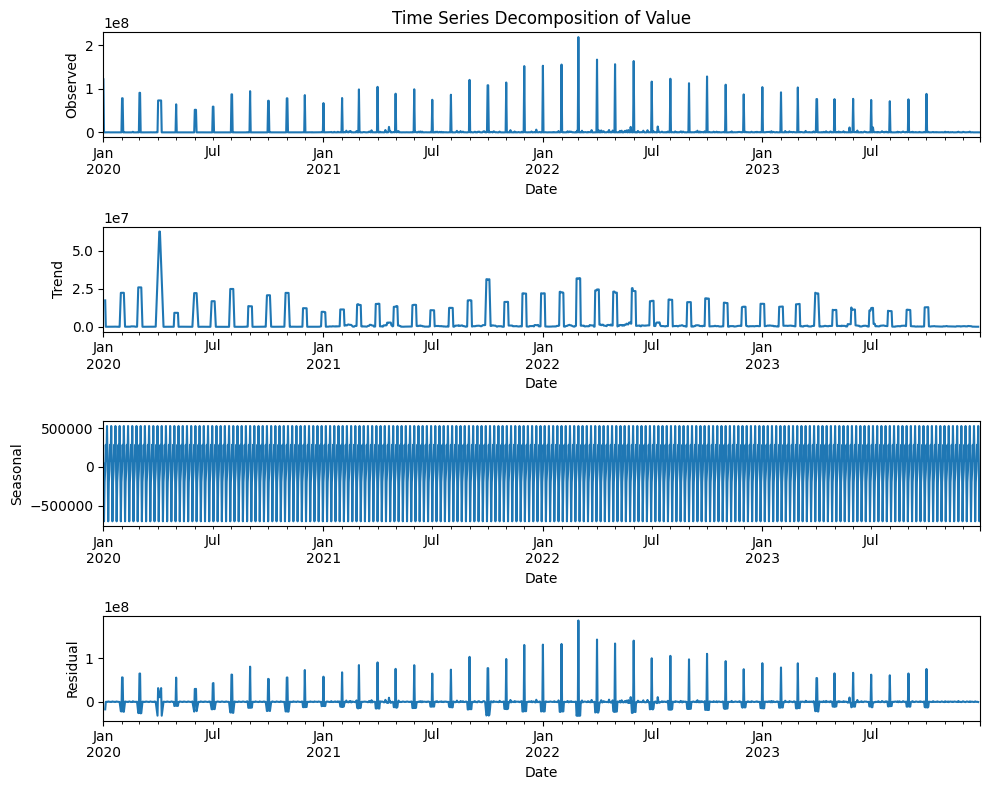

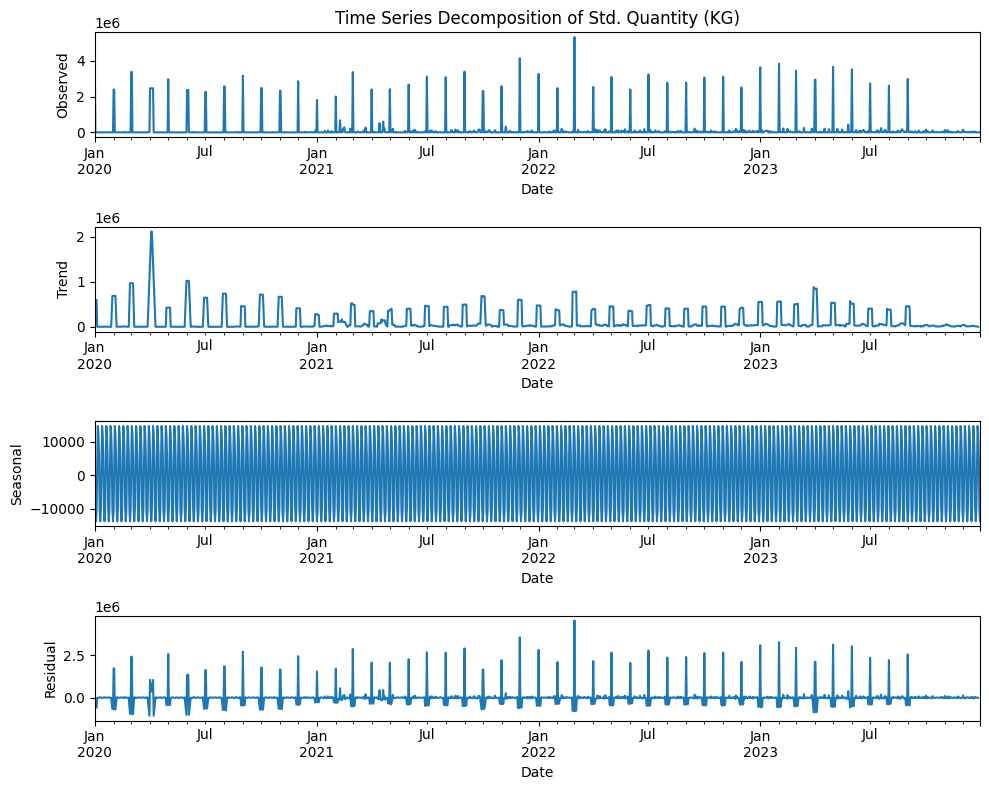

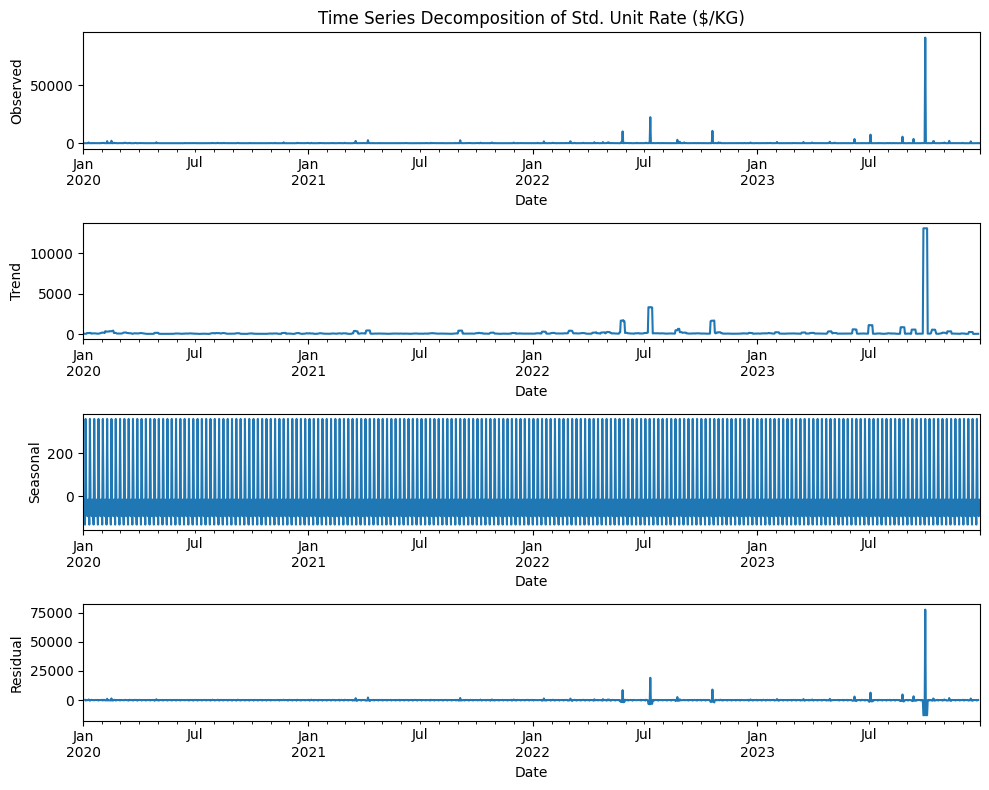

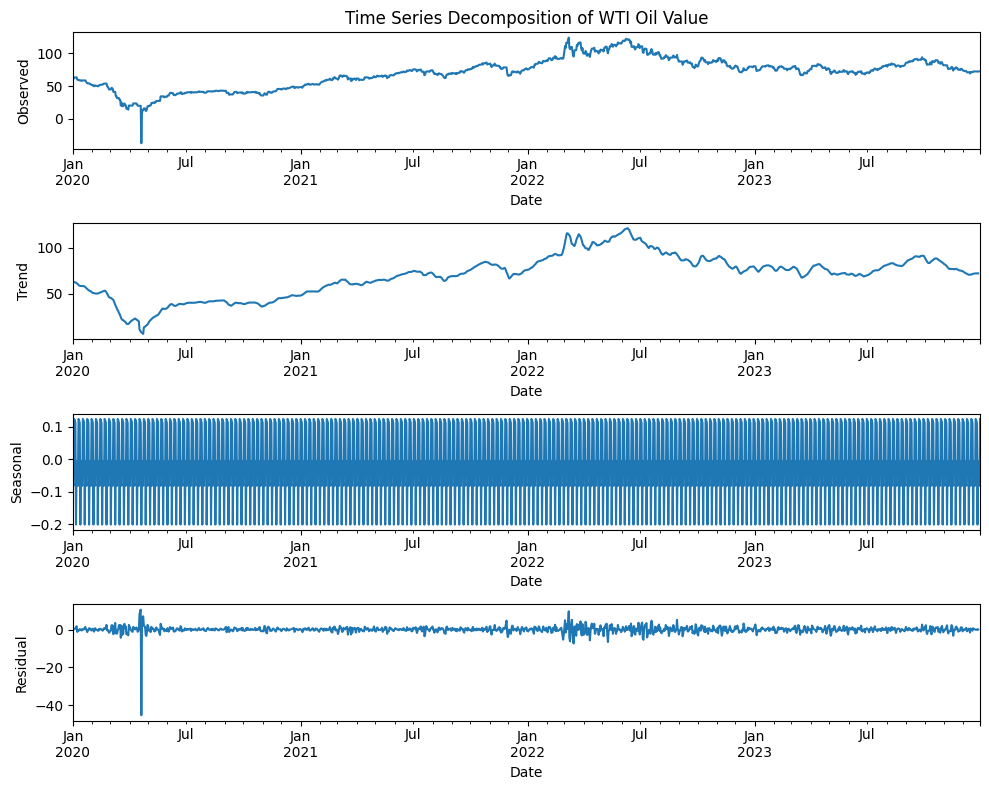

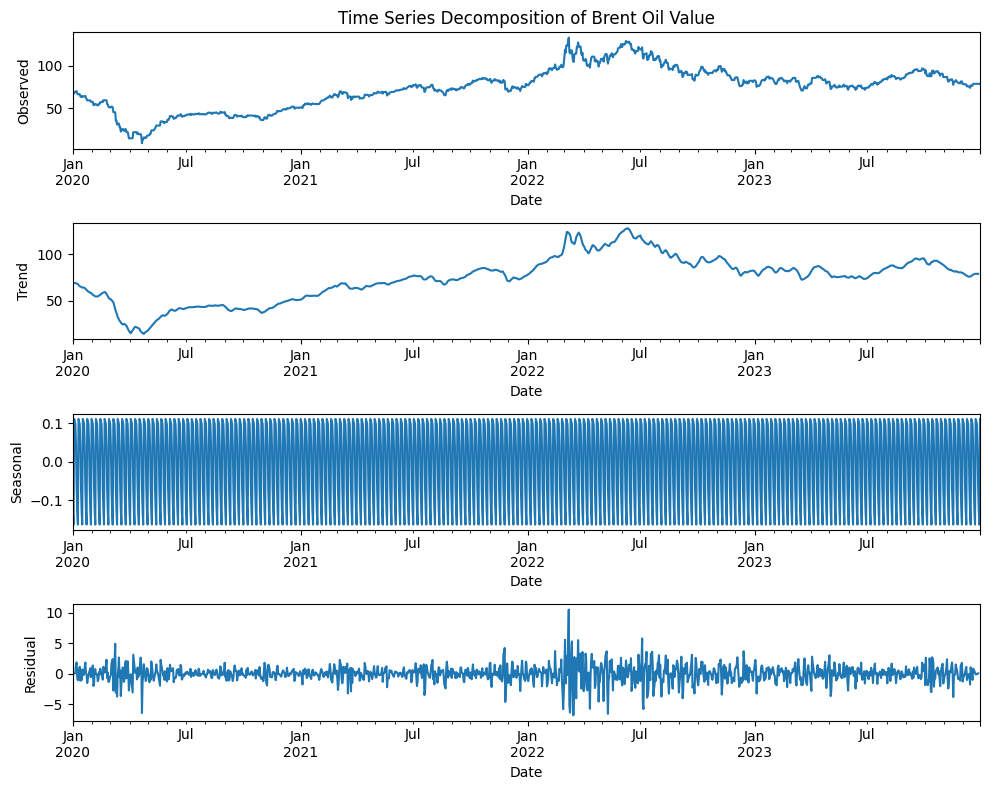

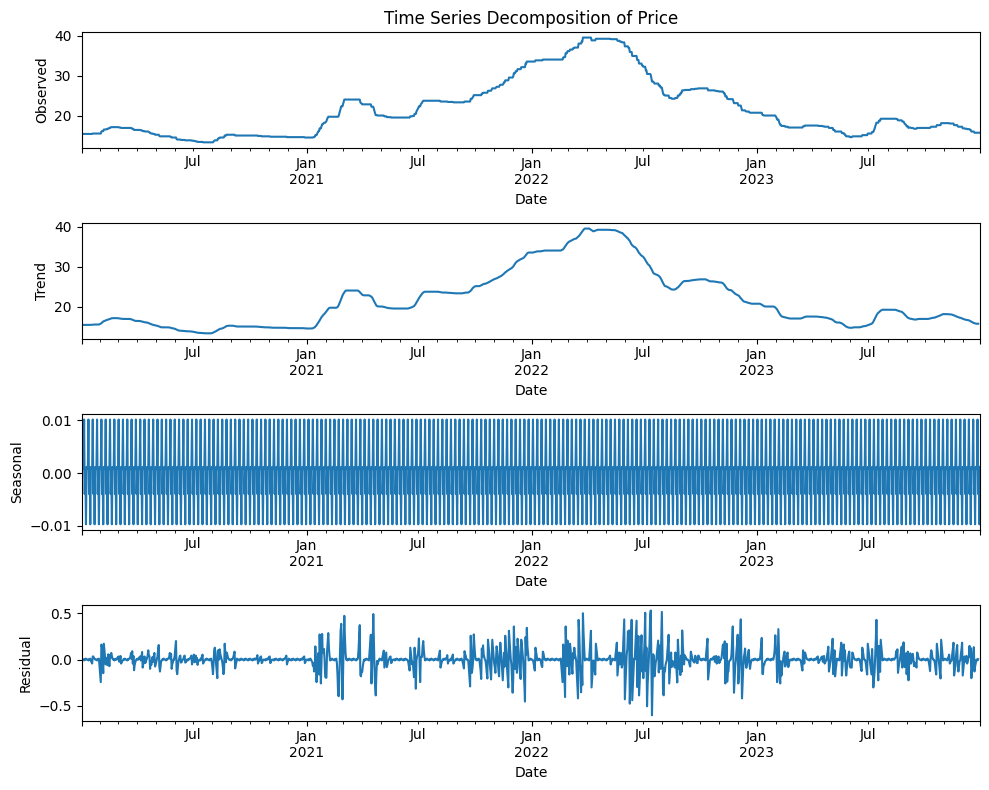

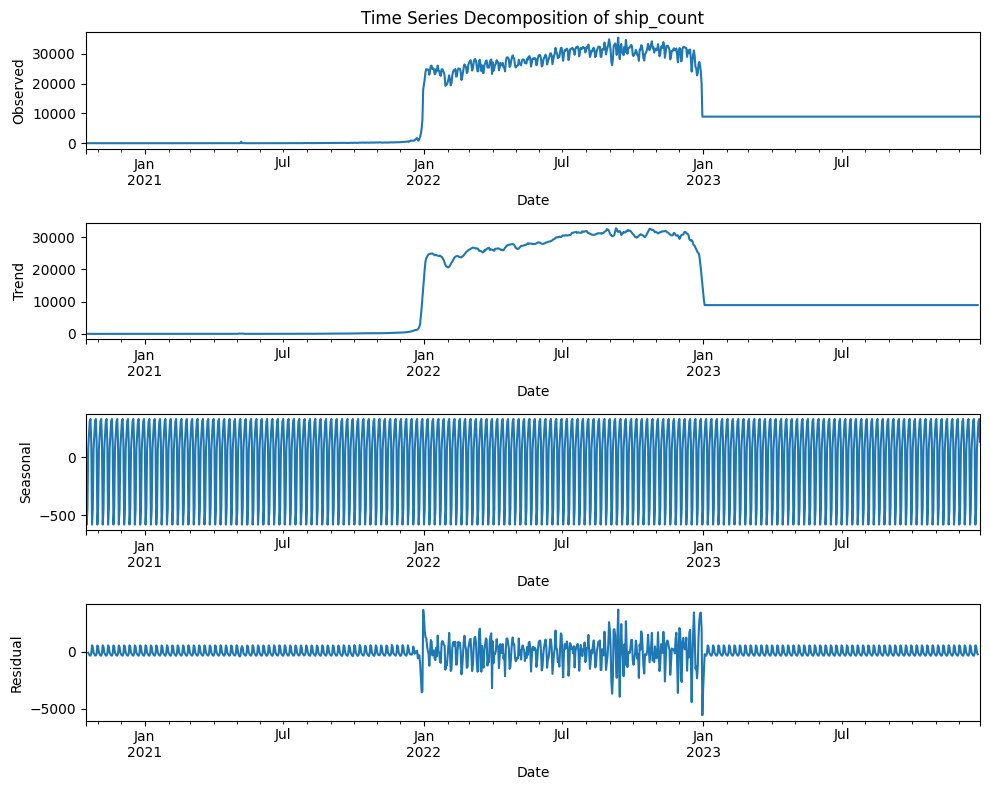

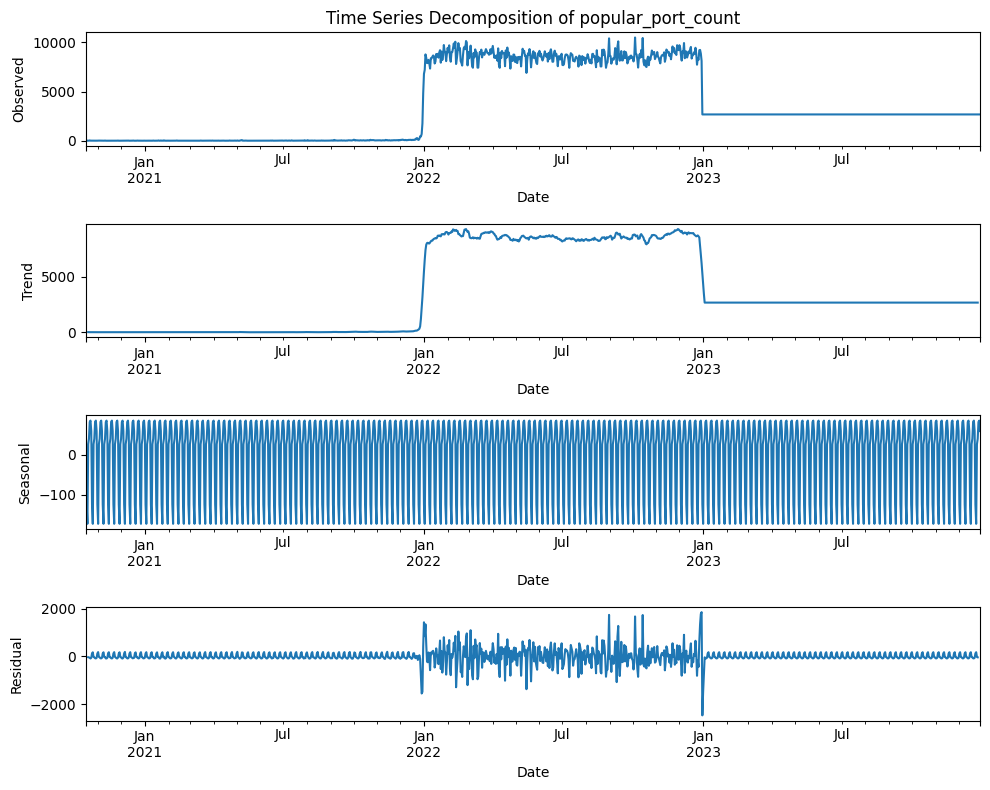

In [41]:
for column in FEATURE_COLUMNS:
    series = df[column].dropna()
    if not series.empty:  
        decomposition = sm.tsa.seasonal_decompose(series, model='additive')

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
        decomposition.observed.plot(ax=ax1)
        ax1.set_ylabel('Observed')
        ax1.set_title(f'Time Series Decomposition of {column}')

        decomposition.trend.plot(ax=ax2)
        ax2.set_ylabel('Trend')

        decomposition.seasonal.plot(ax=ax3)
        ax3.set_ylabel('Seasonal')

        decomposition.resid.plot(ax=ax4)
        ax4.set_ylabel('Residual')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{column}' was skipped due to insufficient data after dropping NaNs.")